In [ ]:
!pip -q uninstall -y transformers tokenizers datasets accelerate huggingface_hub protobuf peft

!pip -q install \
  "protobuf<5.0.0" \
  "transformers==4.44.2" \
  "datasets==2.20.0" \
  "accelerate==0.34.2" \
  "tokenizers>=0.19.1" \
  "huggingface_hub>=0.24" \
  "safetensors>=0.4" \
  "sentencepiece>=0.1.99" \
  "numpy==1.26.4" \
  "scikit-learn==1.3.2" \
  "tqdm"

import os
os.kill(os.getpid(), 9)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 143.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 128.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 31.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviou

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os, json, numpy as np, torch
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
)
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

sns.set_theme()

BASE_DIR = "/content/drive/MyDrive/covid-sentiment"
LANG_TAG = "es"

SAVE_LANG_DIR = f"{BASE_DIR}/{LANG_TAG}"
TOK_DIR  = f"{SAVE_LANG_DIR}/tok_xlmr_256"
BEST_DIR = f"{SAVE_LANG_DIR}/xlmr_{LANG_TAG}_best"

print("TOK_DIR :", TOK_DIR)
print("BEST_DIR:", BEST_DIR)

tok = load_from_disk(TOK_DIR)

with open(f"{BEST_DIR}/label2id.json","r",encoding="utf-8") as f:
    label2id = json.load(f)
with open(f"{BEST_DIR}/id2label.json","r",encoding="utf-8") as f:
    id2label = json.load(f)

num_labels = len(label2id)

tokenizer = AutoTokenizer.from_pretrained(BEST_DIR)
model = AutoModelForSequenceClassification.from_pretrained(
    BEST_DIR,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

Mounted at /content/drive
TOK_DIR : /content/drive/MyDrive/covid-sentiment/es/tok_xlmr_256
BEST_DIR: /content/drive/MyDrive/covid-sentiment/es/xlmr_es_best


In [ ]:
with open(f"{BEST_DIR}/label2id.json","r",encoding="utf-8") as f:
    label2id = json.load(f)
with open(f"{BEST_DIR}/id2label.json","r",encoding="utf-8") as f:
    id2label_raw = json.load(f)

id2label = {int(k): v for k, v in id2label_raw.items()}
num_labels = len(id2label)

print("id2label:", id2label)

id2label: {0: 'negative', 1: 'neutral', 2: 'positive'}


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

collator = DataCollatorWithPadding(
    tokenizer,
    pad_to_multiple_of=8 if torch.cuda.is_available() else None,
)

test_loader = DataLoader(
    tok["test"],
    batch_size=64,
    shuffle=False,
    collate_fn=collator,
)

model.to(device)
model.eval()

all_logits = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        labels = batch["labels"].numpy()
        all_labels.append(labels)

        batch = {k: v.to(device) for k, v in batch.items() if k != "labels"}

        outputs = model(**batch)
        logits = outputs.logits.detach().cpu().numpy()
        all_logits.append(logits)

y_true = np.concatenate(all_labels, axis=0)
y_pred = np.argmax(np.concatenate(all_logits, axis=0), axis=1)

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)
metrics = {
    "accuracy": acc,
    "precision_macro": prec,
    "recall_macro": rec,
    "f1_macro": f1,
}

print(json.dumps(metrics, indent=2))
print(
    classification_report(
        y_true,
        y_pred,
        target_names=[id2label[i] for i in range(num_labels)]
    )
)

Device: cuda


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

{
  "accuracy": 0.8394440767703507,
  "precision_macro": 0.6628929179828971,
  "recall_macro": 0.8763869423034573,
  "f1_macro": 0.7277877647601354
}
              precision    recall  f1-score   support

    negative       0.45      0.91      0.60       676
     neutral       0.99      0.83      0.90      6350
    positive       0.56      0.89      0.69       529

    accuracy                           0.84      7555
   macro avg       0.66      0.88      0.73      7555
weighted avg       0.91      0.84      0.86      7555



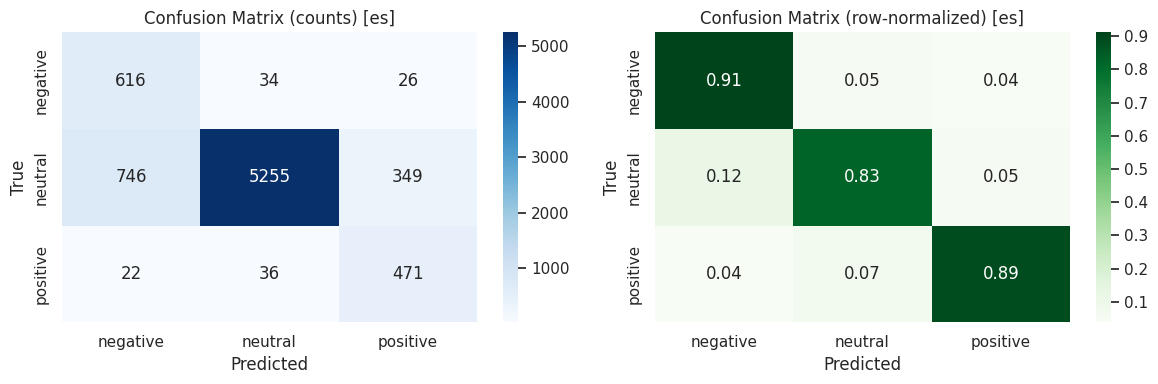

In [6]:
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_labels)))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", ax=ax[0],
    xticklabels=[id2label[i] for i in range(num_labels)],
    yticklabels=[id2label[i] for i in range(num_labels)],
)
ax[0].set_title(f"Confusion Matrix (counts) [{LANG_TAG}]")
ax[0].set_xlabel("Predicted"); ax[0].set_ylabel("True")

sns.heatmap(
    cm_norm, annot=True, fmt=".2f", cmap="Greens", ax=ax[1],
    xticklabels=[id2label[i] for i in range(num_labels)],
    yticklabels=[id2label[i] for i in range(num_labels)],
)
ax[1].set_title(f"Confusion Matrix (row-normalized) [{LANG_TAG}]")
ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("True")

plt.tight_layout()
plt.show()
